# Chapter 3 - Classification

## Setup

In [4]:
# Python >=3.5 is required
import sys
assert sys.version_info >= (3,5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# Common imports
import os
import numpy as np

# to make notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
!matplotlib inline

# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

## MNIST

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist['data'], mnist['target']

In [8]:
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

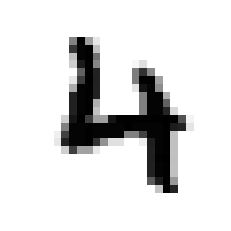

In [15]:
# Taking a peek at the X values
some_digit = X[37000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')

In [16]:
y[37000]

'4'

In [25]:
y = y.astype(np.uint8)

In [26]:
y[37000]

4

In [27]:
# Making a Test and a Train Sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [28]:
# Shuffle the training set for garanteing similarity between cross-validation folds (not true for timeseries data!)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

In [29]:
# Creating target vectors for this classification: 5 or not 5
y_train_5 = (y_train == 5) # True, false list
y_test_5 = (y_test == 5)

In [31]:
y_train_5[y_train_5 == True].shape

(5421,)

In [32]:
# Training the classifier with a Stochastic Gradient Descent (SGD) -> This classifier is well suited for Online 
# Learning
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [33]:
sgd_clf.predict([some_digit])

array([False])

In [36]:
sgd_clf.predict([X[0]])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8735 , 0.87635, 0.87465])

In [38]:
# Comparison with the dumbest model
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1),dtype=bool)

In [40]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90935, 0.90765, 0.91195])

* For skewed datasets accuracy scoring is generally not the preferred performance measurement for classifiers

### Confusion Matrix

In [41]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [43]:
# Building the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53935,   644],
       [ 1308,  4113]])

### Precision and Recall

In [47]:
from sklearn.metrics import precision_score, recall_score

ps = precision_score(y_train_5, y_train_pred)
ps

0.8646205591759513

In [46]:
rs = recall_score(y_train_5, y_train_pred)
rs

0.758716104039845

In [49]:
# My F1 score, the harmonic mean of these two scores -> much more weight to low values -> only get high F1 if both
# scores are high
f1 = 2 * ((ps * rs)/(ps + rs))
f1

0.8082137944586364

In [50]:
# Or...
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.8082137944586364

"The f1 score favours classifiers that have similar precision and recall." But, increasing precision reduces recall and vice-versa: _precision/recall_ tradeoff.

### Precision/Recall Tradeoff

In [51]:
# As a threshold increase so does the precision, but in detriment of the recall
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [52]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [71]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8,3))    
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

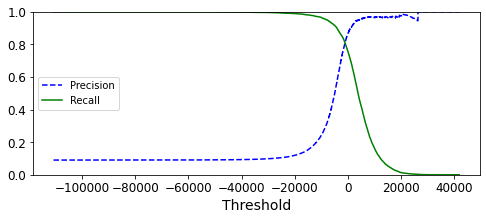

In [72]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds);

Text(0, 0.5, 'Precision')

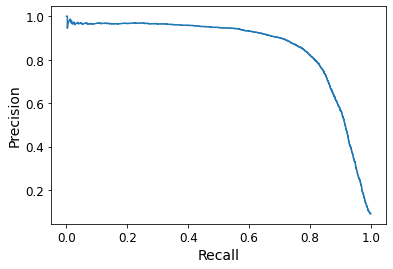

In [74]:
# Plotting precision against recall
plt.plot(recalls, precisions);
plt.xlabel('Recall')
plt.ylabel('Precision')

<font color=blue>"Lets reach 99% precision": "At what recall?"</font>

In [89]:
# Suppose you want 90% precision
y_train_pred_90 = (y_scores > 1500)

In [90]:
precision_score(y_train_5, y_train_pred_90)

0.9087964116620982

In [91]:
recall_score(y_train_5, y_train_pred_90)

0.6727541044087807

### The ROC Curve

In [93]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [94]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # curve of a purely random classifier
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

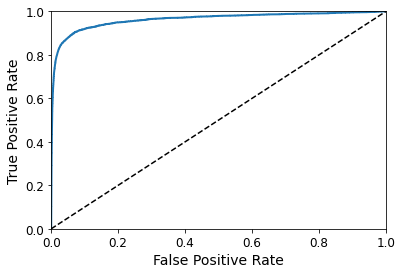

In [95]:
plot_roc_curve(fpr, tpr)

In [96]:
# AUC: area under the curve score
# Perfect classifier ROC_AUC = 1
# Random classifier ROC_AUC = 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9625729450814362

In [97]:
# RandomForestClassifier and Comparisons
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [98]:
# ROC curve needs scores not probabilities, so...
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

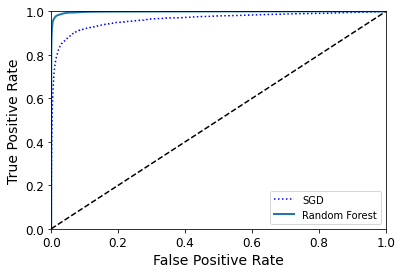

In [99]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

In [100]:
# Incredible, RandomForest performs way better than the StochasticGradientDescent method
roc_auc_score(y_train_5, y_scores_forest)

0.99828510065707

In [107]:
y_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [108]:
precision_score(y_train_5, y_forest_pred)

0.9892699347780349

In [109]:
recall_score(y_train_5, y_forest_pred)

0.8673676443460616

## Multiclass Classification

In [110]:
# Scikit tries to guess if you are trying one of the following strategies for Multiclass Classification
# OvA, OvO
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [111]:
sgd_clf.predict([X[0]]) # which is 5

array([5], dtype=uint8)